In [1]:
import re
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

sns.set_style()

# Prepare Project Gutenberg Metadata Dataset

## Download RDF/XML and Extract to CSV

In [2]:
# from metadata import *
# folder_path = "./data/"

# download_metadata_tar(folder_path)
# extract_metadata_tar(folder_path)
# metadata_to_csv(folder_path)

## Working with Smaller Subset

In [3]:
# books = pd.read_csv("./data/metadata.csv")
# books.drop(columns=["ebook", "publisher", "license", "rights", "available_formats"], inplace=True)
# books.to_csv("./data/metadata-smaller.csv", index=False)

## Import the Smaller Dataset

In [4]:
books = pd.read_csv("./data/metadata-smaller.csv", index_col="book_id")
books = books.rename(columns={"language": "lang_code", "creator_names": "authors"})
books = books.sort_index()

In [5]:
books["issued"] = pd.to_datetime(books["issued"])

In [6]:
books["authors"] = books["authors"].apply(lambda x: [author for author in ast.literal_eval(x) if author != "None"])
books["authors"] = books["authors"].apply(lambda x: "; ".join(x))

In [7]:
books["bookshelves"] = books["bookshelves"].apply(lambda x: [cat for cat in ast.literal_eval(x) if cat != "None"])
books["bookshelves"] = books["bookshelves"].apply(lambda x: "; ".join(x))

In [8]:
books.head()

,type,issued,downloads,title,lang_code,authors,bookshelves
book_id,,,,,,,
1,Text,1971-12-01,2915,The Declaration of Independence of the United ...,en,"Jefferson, Thomas",Politics; American Revolutionary War; United S...
2,Text,1972-12-01,4313,The United States Bill of Rights\r\nThe Ten Or...,en,United States,Politics; American Revolutionary War; United S...
3,Text,1973-11-01,1258,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald)",
4,Text,1973-11-01,1510,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham",US Civil War
5,Text,1975-12-01,1019,The United States Constitution,en,United States,United States; Politics; American Revolutionar...


# Exploratory Analysis

## Book Authors

In [9]:
len(re.findall(";", books["bookshelves"][1])) + 1

3

In [10]:
author_counts = books["authors"].apply(lambda authors: 0 if len(authors) == 0 else len(re.findall(";", authors)) + 1)

In [11]:
# book without author data
np.sum(author_counts == 0)

2677

In [12]:
# average number of author, excluding no author data
author_counts[author_counts != 0].mean()

1.047377835014667

In [13]:
author_counts.value_counts().sort_index()

0      2677
1     67375
2      2115
3       231
4        83
5        39
6        16
7         5
8         7
9         2
10        3
11        1
12        1
13        4
14        1
23        1
24        1
Name: authors, dtype: int64

In [14]:
top_title_author_counts = pd.concat([books["title"], author_counts], axis=1) \
    .sort_values("authors", ascending=False) \
    .head(15) \
    .reset_index(drop=True)
    
top_title_author_counts["title"] = top_title_author_counts["title"].apply(lambda x: re.sub("(\r|\n)+", " ", x))

# display as HTML to prevent data trunctation
display(HTML(top_title_author_counts.to_html()))

,title,authors
0,Atlantic Narratives: Modern Short Stories; Second Series,24
1,Atlantic Narratives: Modern Short Stories,23
2,Special Report on Diseases of Cattle,14
3,Modern Poets and Poetry of Spain,13
4,"La voz de la conseja, t.1 Selección de las mejores novelas breves y cuentos de los más esclarecidos literatos",13
5,"La voz de la conseja, t.2 Selección de las mejores novelas breves y cuentos de los más esclarecidos literatos",13
6,"Argentina, Legend and History",13
7,The Whole Family: a Novel by Twelve Authors,12
8,Eleven Possible Cases,11
9,"Väriä ja viivoja: Werner von Heidenstamin, Oscar Levertinin y.m. novelleja",10


## Bookshelves Categories

In [15]:
bookshelf_cat_counts = books["bookshelves"].apply(lambda bookshelves: 0 if len(bookshelves) == 0 else len(re.findall(";", bookshelves)) + 1)

In [16]:
# no bookshelve category data
np.sum(bookshelf_cat_counts == 0)

55394

In [17]:
bookshelf_cat_counts[bookshelf_cat_counts != 0].mean()

1.1742194780987885

In [18]:
bookshelf_categories = []

for book_categories in books["bookshelves"]:
    for category in book_categories.split(";"):
        category = category.strip()
        if category not in bookshelf_categories and category != "None" and category != "":
            bookshelf_categories.append(category)

print(f"There are {len(bookshelf_categories)} bookshelf categories.")

There are 338 bookshelf categories.


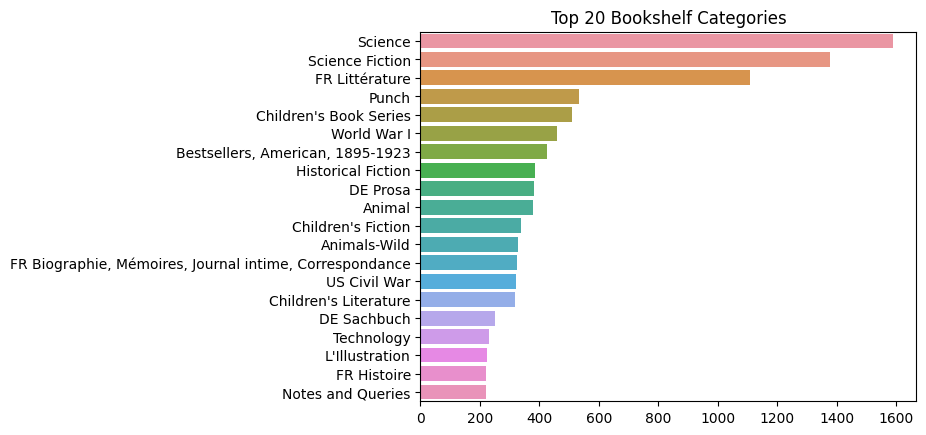

In [19]:
category_df = pd.DataFrame(np.zeros((books.shape[0], len(bookshelf_categories)), dtype=bool),
                           columns = bookshelf_categories,
                           index = books.index)

for category in bookshelf_categories:
    category_df[category] = books["bookshelves"].apply(lambda bookshelves: category in bookshelves)

category_counts = category_df.sum(axis=0).sort_values(ascending=False).head(20)

sns.barplot(y=category_counts.index, x=category_counts.values)
plt.title("Top 20 Bookshelf Categories")
plt.show()

In [20]:
top_title_category_count = pd.concat([books["title"], category_df.sum(axis=1)], axis=1) \
    .rename(columns={0:"n_category"}) \
    .sort_values("n_category", ascending=False) \
    .head(15) \
    .reset_index(drop=True)
    
top_title_category_count["title"] = top_title_category_count["title"].apply(lambda x: re.sub("(\r|\n)+", " ", x))

# display as HTML to prevent data trunctation
display(HTML(top_title_category_count.to_html()))

,title,n_category
0,The call of the wild,7
1,The Strange Case of Dr. Jekyll and Mr. Hyde,6
2,"Birds, Illustrated by Color Photography, Vol. 1, No. 5 May, 1897",6
3,Birds of the Indian Hills,6
4,"Birds, Illustrated by Color Photography, Vol. 2, No. 2 August, 1897",6
5,"Birds, Illustrated by Color Photography, Vol. 1, No. 4 April, 1897",6
6,"Frankenstein; Or, The Modern Prometheus",6
7,The Strange Case of Dr. Jekyll and Mr. Hyde,5
8,Discours de la méthode,5
9,"Birds, Illustrated by Color Photography, Vol. 2, No. 6 December, 1897",5


## Language

In [21]:
# from languages import *
# download_language_reference()

In [22]:
languages = pd.read_csv("./data/languages.csv").fillna("-").iloc[:, [0, 3, 4]]
languages.head()

,639-2[1],639-1,Language name(s) from ISO 639-2[1]
0,aar,aa,Afar
1,abk,ab,Abkhazian
2,ace,-,Achinese
3,ach,-,Acoli
4,ada,-,Adangme


In [23]:
lang_codes_ref = {}

for code in books["lang_code"].unique():
    if len(code) == 2:
        lang_codes_ref[code] = languages.loc[languages["639-1"] == code, "Language name(s) from ISO 639-2[1]"].values
    if len(code) == 3:
        lang_codes_ref[code] = languages.loc[languages["639-2[1]"] == code, "Language name(s) from ISO 639-2[1]"].values
        
lang_codes_ref = pd.DataFrame(lang_codes_ref.values(), index=lang_codes_ref.keys(), columns=["language"])

lang_codes_ref.loc["ia", :] = "Interlingua"
lang_codes_ref.loc["ro", :] = "Romanian; Moldovan"
lang_codes_ref.loc["rmr", :] = "Caló"

lang_codes_ref.head()

,language
en,English
la,Latin
es,Spanish; Castilian
de,German
fr,French


In [24]:
books = books.join(lang_codes_ref, on="lang_code")

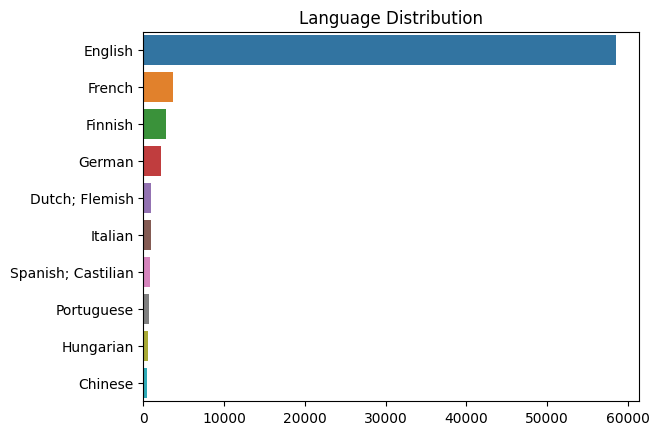

In [25]:
language_counts = books["language"].value_counts().head(10)

sns.barplot(y=language_counts.index, x=language_counts.values)
plt.title("Language Distribution")
plt.show()

# Downloads

In [26]:
top_downloaded_books = books[["title", "authors", "downloads"]] \
    .sort_values("downloads", ascending=False) \
    .head(15) \
    .reset_index(drop=True)

# display as HTML to prevent data trunctation
display(HTML(top_downloaded_books.to_html()))

,title,authors,downloads
0,A Christmas Carol in Prose; Being a Ghost Story of Christmas,"Dickens, Charles",73366
1,"Frankenstein; Or, The Modern Prometheus","Shelley, Mary Wollstonecraft",60961
2,"Moby Dick; Or, The Whale","Melville, Herman",59536
3,Romeo and Juliet,"Shakespeare, William",51927
4,Pride and Prejudice,"Austen, Jane",50914
5,Middlemarch,"Eliot, George",47131
6,A Room with a View,"Forster, E. M. (Edward Morgan)",46375
7,The Complete Works of William Shakespeare,"Shakespeare, William",44424
8,"Little Women; Or, Meg, Jo, Beth, and Amy","Alcott, Louisa May",43524
9,The Blue Castle: a novel,"Montgomery, L. M. (Lucy Maud)",40659


In [27]:
# the most downloaded non-English books
top_downloaded_books = books[["title", "authors", "language", "downloads"]] \
    .loc[books["language"] != "English"] \
    .sort_values("downloads", ascending=False) \
    .head(15) \
    .reset_index(drop=True)

# display as HTML to prevent data trunctation
display(HTML(top_downloaded_books.to_html()))

,title,authors,language,downloads
0,Don Quijote,"Cervantes Saavedra, Miguel de",Spanish; Castilian,8693
1,Noli Me Tangere,"Rizal, José",Tagalog,6074
2,Josefine Mutzenbacher\noder Die Geschichte einer Wienerischen Dirne von ihr selbst erzählt,"Salten, Felix",German,5831
3,Tractatus Logico-Philosophicus,"Wittgenstein, Ludwig",German,4922
4,"Ang ""Filibusterismo"" (Karugtóng ng Noli Me Tangere)","Rizal, José",Tagalog,4753
5,Die Verwandlung,"Kafka, Franz",German,3862
6,Novo dicionário da língua portuguesa,"Figueiredo, Cândido de",Portuguese,3500
7,"Chaucer's Works, Volume 4 — The Canterbury Tales","Chaucer, Geoffrey","English, Middle (1100–1500)",3223
8,Der Struwwelpeter\noder lustige Geschichten und drollige Bilder,"Hoffmann, Heinrich",German,2305
9,1001 задача для умственного счета,"Rachinskii, Sergei Aleksandrovich",Russian,2170


In [28]:
import pandas as pd
category_download_counts = []

books_with_category = books.join(category_df)

for category in bookshelf_categories:
    downloads = books["downloads"].loc[books_with_category[category]].sum()
    n_items = books_with_category[category].sum()
    
    row = {}
    row["category"] = category
    row["downloads"] = downloads
    row["n_items"] = n_items
    row["downloads_per_items"] = downloads / n_items
    
    category_download_counts.append(row)

category_download_counts = pd.DataFrame(category_download_counts)

In [29]:
category_download_counts \
    .sort_values("downloads_per_items", ascending=False) \
    .head(15) \
    .reset_index(drop=True)

,category,downloads,n_items,downloads_per_items
0,Gothic Fiction,151156,30,5038.533333
1,Banned Books List from the American Library As...,53142,15,3542.800000
2,Best Books Ever Listings,613993,206,2980.548544
3,Precursors of Science Fiction,95234,36,2645.388889
4,Movie Books,311640,119,2618.823529
5,Mystery Fiction,32947,13,2534.384615
6,Horror,95569,49,1950.387755
7,American Revolutionary War,9506,5,1901.200000
8,Erotic Fiction,26313,16,1644.562500
9,Harvard Classics,282820,185,1528.756757


In [30]:
category_download_counts \
    .sort_values("downloads", ascending=False) \
    .head(15) \
    .reset_index(drop=True)

,category,downloads,n_items,downloads_per_items
0,Best Books Ever Listings,613993,206,2980.548544
1,Movie Books,311640,119,2618.823529
2,Science,285752,1589,179.831340
3,Harvard Classics,282820,185,1528.756757
4,Science Fiction,273235,1376,198.571948
5,Children's Literature,264586,317,834.656151
6,Banned Books from Anne Haight's list,259737,174,1492.741379
7,Historical Fiction,244590,384,636.953125
8,Gothic Fiction,151156,30,5038.533333
9,Christmas,131795,151,872.814570


# Release Date

<AxesSubplot: >

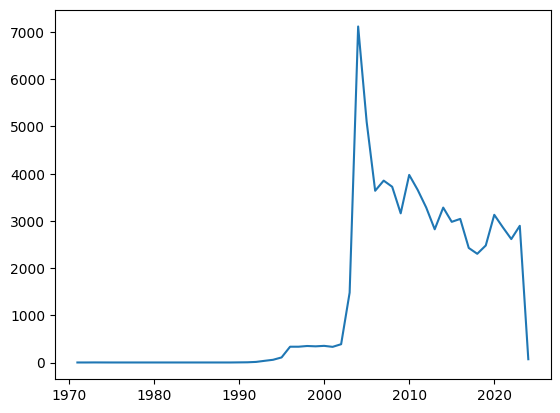

In [31]:
year_counts = books["issued"].map(lambda x: x.year).value_counts().sort_index()

sns.lineplot(x=year_counts.index, y=year_counts.values)